In [ ]:
# ============================================
# 1) Setup
# ============================================
!pip -q install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.5 MB/s eta 0:00:00


[I 2025-09-10 05:13:24,237] A new study created in memory with name: no-name-b1d54e7f-e28e-419b-b9cb-b4996e09768e


Data rows: 432, features: 20


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-09-10 05:13:43,573] Trial 0 finished with value: 0.31649891441536787 and parameters: {'d_model': 128, 'num_heads': 8, 'ff_dim': 64, 'dropout': 0.17930387595513841, 'lr': 0.003215852310440591, 'batch_size': 64, 'time_steps': 6}. Best is trial 0 with value: 0.31649891441536787.
[I 2025-09-10 05:14:01,718] Trial 1 finished with value: 0.3341027509597085 and parameters: {'d_model': 128, 'num_heads': 8, 'ff_dim': 64, 'dropout': 0.25485466815381974, 'lr': 0.0014970893104842985, 'batch_size': 32, 'time_steps': 4}. Best is trial 0 with value: 0.31649891441536787.


[I 2025-09-10 05:14:29,740] Trial 2 finished with value: 0.37882914759811454 and parameters: {'d_model': 128, 'num_heads': 2, 'ff_dim': 64, 'dropout': 0.34055669808930933, 'lr': 0.00013889010061872187, 'batch_size': 64, 'time_steps': 4}. Best is trial 0 with value: 0.31649891441536787.
[I 2025-09-10 05:14:53,696] Trial 3 finished with value: 0.2720322478185356 and parameters: {'d_model': 128, 'num_heads': 8, 'ff_dim': 64, 'dropout': 0.17213672184659312, 'lr': 0.003090200199720069, 'batch_size': 32, 'time_steps': 12}. Best is trial 3 with value: 0.2720322478185356.
[I 2025-09-10 05:15:38,965] Trial 4 finished with value: 0.30369578504229455 and parameters: {'d_model': 128, 'num_heads': 2, 'ff_dim': 256, 'dropout': 0.2236833645626113, 'lr': 0.0004301789827400343, 'batch_size': 32, 'time_steps': 12}. Best is trial 3 with value: 0.2720322478185356.
[I 2025-09-10 05:16:09,325] Trial 5 finished with value: 0.30136202502535503 and parameters: {'d_model': 128, 'num_heads': 4, 'ff_dim': 256, 'd

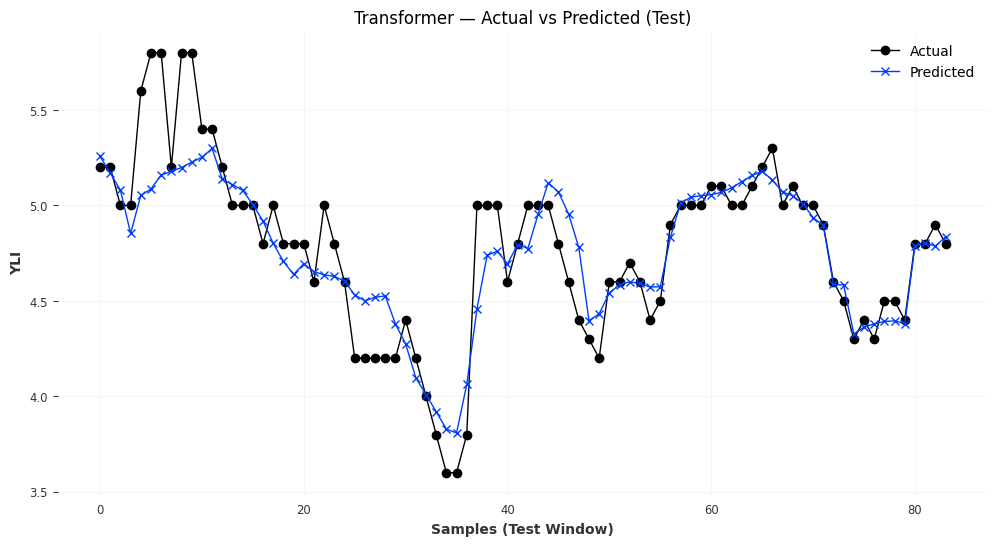


Saved model + scalers + params to: /content/transformer_yli


In [ ]:
import os
import numpy as np
import pandas as pd
import optuna
import tensorflow as tf
from tensorflow.keras.layers import (Input, MultiHeadAttention, LayerNormalization,
                                     Dense, Dropout, GlobalAveragePooling1D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 2) Config / Paths
# ============================================
CSV_PATH = '/content/drive/MyDrive/AGRI/Forecasting/yli_raw2.csv'
TARGET_COL = 'YLI'
DROP_COLS = ['Control']  # safely ignored if not present
TEST_SIZE = 0.2          # 20% test split AFTER making sequences
VAL_SIZE = 0.2           # 20% of train for validation
NUM_TRIALS = 25          # increase for better search (e.g., 50-100)
MAX_EPOCHS = 150

# ============================================
# 3) Utilities
# ============================================
def load_and_clean(csv_path, target_col, drop_cols=None):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # Convert all columns to numeric where possible
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Drop optional columns if present
    if drop_cols:
        for c in drop_cols:
            if c in df.columns:
                df.drop(columns=[c], inplace=True, errors='ignore')

    # Fill then drop remaining NA
    df.bfill(inplace=True)
    df.dropna(inplace=True)

    # Ensure target presence
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in data.")

    return df

def create_sequences(X, y, time_steps):
    """Make rolling sequences of length `time_steps` to predict next-step y."""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

def nse_score(y_true, y_pred):
    """Nash–Sutcliffe Efficiency."""
    num = np.sum((y_true - y_pred)**2)
    den = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (num / den)

def build_transformer_model(input_timesteps, n_features, d_model, num_heads, ff_dim, dropout):
    """Single-layer Transformer encoder -> pooling -> dense(1)."""
    inputs = Input(shape=(input_timesteps, n_features))

    # Self attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward block with residual
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(n_features, activation='relu')(ff)  # project back to match residual shape
    x = x + ff
    x = LayerNormalization(epsilon=1e-6)(x)

    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

def train_eval_once(params, X, y, scaler_y):
    """
    Given hyperparameters in `params`, builds sequences and trains a model with an
    internal train/val split, then evaluates on a held-out test split.
    Returns RMSE on test (lower is better for Optuna).
    """
    # Unpack params
    time_steps = params['time_steps']

    # Rebuild sequences with this time_steps
    X_seq, y_seq = create_sequences(X, y, time_steps)
    if len(X_seq) < 20:
        # not enough samples to split/train — penalize this trial
        return 1e9

    # Split into train/val/test
    # First split off TEST from the end (time-order friendly: we’ll do simple splits)
    N = len(X_seq)
    test_count = int(N * TEST_SIZE)
    if test_count == 0: test_count = 1
    X_trainval, X_test = X_seq[:-test_count], X_seq[-test_count:]
    y_trainval, y_test = y_seq[:-test_count], y_seq[-test_count:]

    # Now split train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=VAL_SIZE, shuffle=True, random_state=42
    )

    # Build & compile model
    n_features = X_seq.shape[2]
    model = build_transformer_model(
        input_timesteps=time_steps,
        n_features=n_features,
        d_model=params['d_model'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout=params['dropout']
    )
    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

    # Train
    model.fit(
        X_train, y_train,
        epochs=MAX_EPOCHS,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predict on test and compute RMSE in ORIGINAL scale
    y_pred = model.predict(X_test, verbose=0).reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # y was scaled — inverse transform back to original units
    y_pred_orig = scaler_y.inverse_transform(y_pred).ravel()
    y_test_orig = scaler_y.inverse_transform(y_test).ravel()

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    return rmse

# ============================================
# 4) Load & Scale Data (features and target)
# ============================================
df = load_and_clean(CSV_PATH, TARGET_COL, drop_cols=DROP_COLS)

# Separate features/target
y_raw = df[TARGET_COL].values.reshape(-1, 1)
X_raw = df.drop(columns=[TARGET_COL]).values

# Scale X with MinMax (0..1), y with StandardScaler (mean=0, std=1)
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).ravel()

print(f"Data rows: {len(df)}, features: {X_scaled.shape[1]}")

# ============================================
# 5) Optuna Hyperparameter Search
# ============================================
def objective(trial):
    params = {
        # Transformer dims
        'd_model': trial.suggest_categorical('d_model', [32, 64, 128]),
        'num_heads': trial.suggest_categorical('num_heads', [2, 4, 8]),
        'ff_dim': trial.suggest_categorical('ff_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.05, 0.35),

        # Optimization
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),

        # Sequence length
        'time_steps': trial.suggest_categorical('time_steps', [4, 6, 8, 12])
    }

    # set d_model compatible with num_heads (d_model % num_heads == 0)
    d_model = params['d_model']
    heads = params['num_heads']
    if d_model % heads != 0:
        # force compatibility by skipping (penalize)
        return 1e9

    rmse = train_eval_once(params, X_scaled, y_scaled, scaler_y)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=NUM_TRIALS, show_progress_bar=True)

print("\nBest trial:")
print(f"  RMSE: {study.best_value:.6f}")
print("  Params:", study.best_params)

best_params = study.best_params

# ============================================
# 6) Refit Best Model on Train+Val and Evaluate on Test
# ============================================
time_steps = best_params['time_steps']

# Build sequences with best time_steps
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# chronological split for final evaluation
N = len(X_seq)
test_count = int(N * TEST_SIZE)
test_count = max(test_count, 1)
X_trainval, X_test = X_seq[:-test_count], X_seq[-test_count:]
y_trainval, y_test = y_seq[:-test_count], y_seq[-test_count:]

# Further split a bit of val for callbacks
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SIZE, shuffle=True, random_state=42
)

model = build_transformer_model(
    input_timesteps=time_steps,
    n_features=X_seq.shape[2],
    d_model=best_params['d_model'],
    num_heads=best_params['num_heads'],
    ff_dim=best_params['ff_dim'],
    dropout=best_params['dropout']
)
model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse')

es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=MAX_EPOCHS,
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[es, rlrop]
)

# Evaluate on test in ORIGINAL units
y_pred = model.predict(X_test).reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_pred_orig = scaler_y.inverse_transform(y_pred).ravel()
y_test_orig = scaler_y.inverse_transform(y_test).ravel()

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2  = r2_score(y_test_orig, y_pred_orig)
nse = nse_score(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / np.maximum(np.abs(y_test_orig), 1e-8))) * 100

print("\n================ METRICS (Test, original units) ================")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"R²   : {r2:.6f}")
print(f"NSE  : {nse:.6f}")
print(f"MAPE : {mape:.3f}%")

# ============================================
# 7) Plot Actual vs Predicted
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual', marker='o', linewidth=1)
plt.plot(y_pred_orig, label='Predicted', marker='x', linewidth=1)
plt.title('Transformer — Actual vs Predicted (Test)')
plt.xlabel('Samples (Test Window)')
plt.ylabel(TARGET_COL)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ============================================
# 8) Save Artifacts
# ============================================
SAVE_DIR = '/content/transformer_yli'
os.makedirs(SAVE_DIR, exist_ok=True)

model.save(os.path.join(SAVE_DIR, 'best_transformer.h5'))

# Save scalers for later inference
import joblib
joblib.dump(scaler_X, os.path.join(SAVE_DIR, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(SAVE_DIR, 'scaler_y.pkl'))

# Save best params
pd.Series(best_params).to_json(os.path.join(SAVE_DIR, 'best_params.json'))

print(f"\nSaved model + scalers + params to: {SAVE_DIR}")


In [ ]:
import os
import numpy as np
import pandas as pd
import optuna
import tensorflow as tf
from tensorflow.keras.layers import (Input, MultiHeadAttention, LayerNormalization,
                                     Dense, Dropout, GlobalAveragePooling1D, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta

[I 2025-09-08 05:40:33,560] A new study created in memory with name: no-name-d8efe3d0-e968-46f6-854d-138dae571330


Loading YLI data for future forecasting...

DATA ANALYSIS:
Dataset length: 432 days
YLI range: 3.6000 to 6.4000
YLI mean: 5.0606, std: 0.5174
Recent 10 values: [4.3 4.4 4.3 4.5 4.5 4.4 4.8 4.8 4.9 4.8]
Recent mean: 4.5700 vs Overall mean: 5.0606

Optimizing hyperparameters for 7-day future forecasting...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-08 05:40:50,469] Trial 0 finished with value: 0.5097065519870937 and parameters: {'d_model': 64, 'num_heads': 2, 'ff_dim': 64, 'dropout': 0.35371868466548173, 'lr': 0.0009725702445506197, 'batch_size': 32, 'time_steps': 7, 'method': 'direct'}. Best is trial 0 with value: 0.5097065519870937.
[I 2025-09-08 05:41:55,138] Trial 1 finished with value: 13.141043143684504 and parameters: {'d_model': 64, 'num_heads': 4, 'ff_dim': 256, 'dropout': 0.17475117852777983, 'lr': 0.0032142035689348455, 'batch_size': 16, 'time_steps': 14, 'method': 'iterative'}. Best is trial 0 with value: 0.5097065519870937.
[I 2025-09-08 05:42:54,680] Trial 2 finished with value: 13.599048893652377 and parameters: {'d_model': 128, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.3626895549058532, 'lr': 0.0002714000397730658, 'batch_size': 32, 'time_steps': 21, 'method': 'iterative'}. Best is trial 0 with value: 0.5097065519870937.
[I 2025-09-08 05:43:06,184] Trial 3 finished with value: 0.5412188911228843 and pa

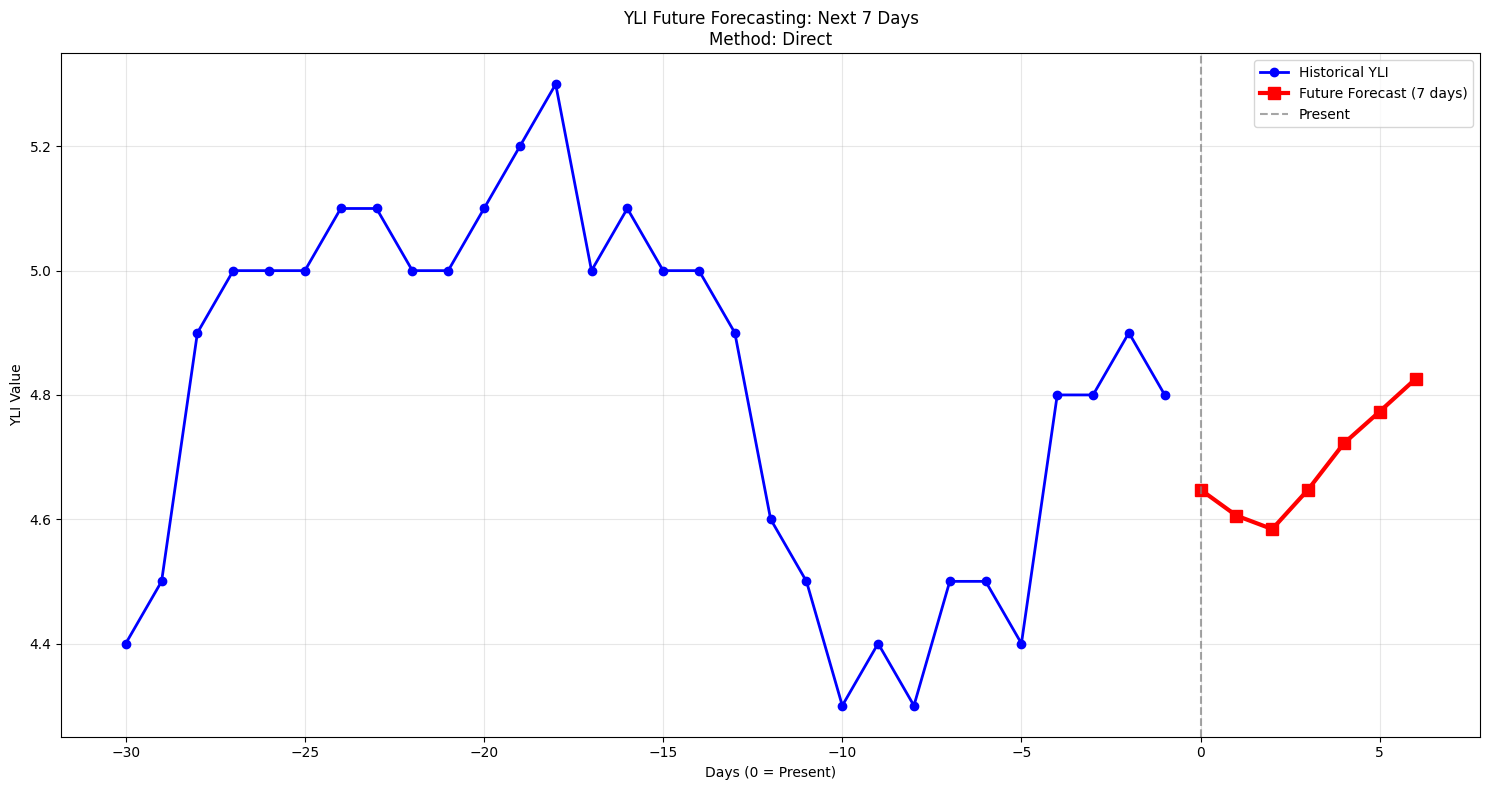

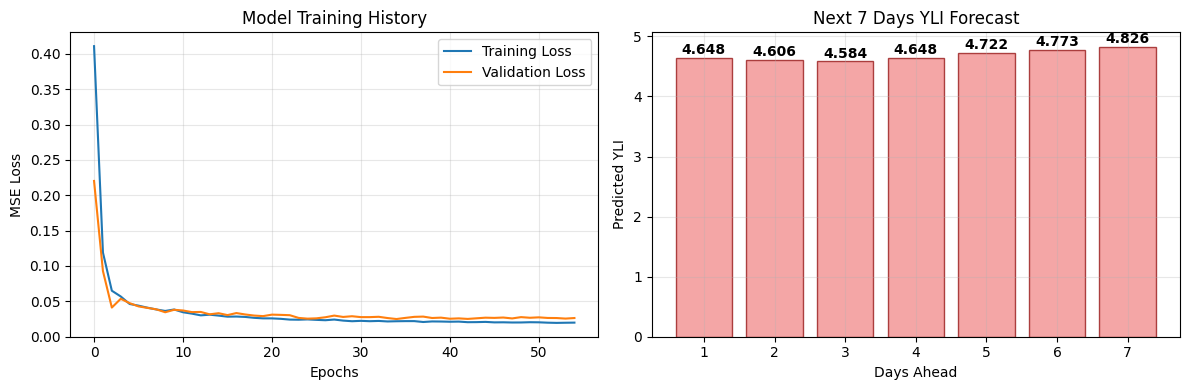


RESULTS SAVED
Directory: /content/yli_future_forecast_7day
Files saved:
  - yli_future_model_direct.h5 (trained model)
  - scaler_y.pkl (data scaler)
  - future_forecast_results.json (complete results)
  - future_predictions.csv (predictions table)

SUMMARY:
Method used: Direct
Validation RMSE: 0.4501
Future predictions saved for next 7 days!

FUTURE YLI FORECAST SUMMARY
Day  Predicted_YLI
 +1       4.647527
 +2       4.605813
 +3       4.584081
 +4       4.647547
 +5       4.722014
 +6       4.773297
 +7       4.825665


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 1) Config - Modified for Future Forecasting
# ============================================
CSV_PATH = '/content/drive/MyDrive/AGRI/Forecasting/yli_raw2.csv'
TARGET_COL = 'YLI'
FORECAST_DAYS = 7       # Days to forecast into the future
TEST_SIZE = 0.2         # For validation only
VAL_SIZE = 0.2
NUM_TRIALS = 20
MAX_EPOCHS = 100

# ============================================
# 2) Utilities for Future Forecasting
# ============================================
def load_yli_univariate(csv_path, target_col):
    """Load univariate YLI data."""
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df.bfill(inplace=True)
    df.dropna(inplace=True)
    return df[[target_col]]

def create_sequences_univariate(series, time_steps, forecast_horizon=1):
    """
    Generate univariate sequences for multi-step forecasting.
    For training: predicts next `forecast_horizon` steps given `time_steps` history
    """
    Xs, ys = [], []
    for i in range(len(series) - time_steps - forecast_horizon + 1):
        Xs.append(series[i:i+time_steps])
        ys.append(series[i+time_steps : i+time_steps+forecast_horizon])
    return np.array(Xs), np.array(ys)

def create_sequences_for_validation(series, time_steps):
    """
    Create sequences for validation where we know the true future values.
    Used to evaluate model performance during hyperparameter tuning.
    """
    return create_sequences_univariate(series, time_steps, FORECAST_DAYS)

def nse_score(y_true, y_pred):
    """Nash-Sutcliffe Efficiency."""
    num = np.sum((y_true - y_pred)**2)
    den = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (num/den)

def forecast_future_sequence(model, last_sequence, scaler, steps_ahead):
    """
    Forecast multiple steps into the future using iterative prediction.
    This generates truly future values beyond the training data.
    """
    current_sequence = last_sequence.copy()
    predictions = []

    for step in range(steps_ahead):
        # Predict next value
        pred_scaled = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)[0, 0]

        # Store prediction
        predictions.append(pred_scaled)

        # Update sequence for next prediction (rolling window)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred_scaled

    # Convert predictions back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_orig = scaler.inverse_transform(predictions).ravel()

    return predictions_orig

def forecast_future_direct(model, last_sequence, scaler):
    """
    Direct multi-step forecasting (if model outputs 7 values at once).
    """
    pred_scaled = model.predict(last_sequence.reshape(1, -1, 1), verbose=0)
    pred_orig = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    return pred_orig

# ============================================
# 3) Transformer Models
# ============================================
def build_transformer_iterative(input_timesteps, d_model, num_heads, ff_dim, dropout):
    """
    Transformer for iterative forecasting (predicts 1 step ahead).
    Used with forecast_future_sequence() for multi-step predictions.
    """
    inputs = Input(shape=(input_timesteps, 1))

    # Project to d_model dimension
    x = Dense(d_model)(inputs)

    # Self-attention
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Pooling and output
    pooled = GlobalAveragePooling1D()(x)
    out = Dense(1, activation='linear')(pooled)  # Predict 1 step

    return Model(inputs, out)

def build_transformer_direct(input_timesteps, d_model, num_heads, ff_dim, dropout, forecast_days):
    """
    Transformer for direct multi-step forecasting (predicts all 7 days at once).
    """
    inputs = Input(shape=(input_timesteps, 1))

    # Project to d_model dimension
    x = Dense(d_model)(inputs)

    # Self-attention
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Pooling and output
    pooled = GlobalAveragePooling1D()(x)
    out = Dense(forecast_days, activation='linear')(pooled)  # Predict 7 steps

    return Model(inputs, out)

# ============================================
# 4) Load YLI Data
# ============================================
print("Loading YLI data for future forecasting...")
df = load_yli_univariate(CSV_PATH, TARGET_COL)
y_raw = df[TARGET_COL].values.reshape(-1, 1)

# Scale the data
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw).ravel()

# Add data analysis section before training
print(f"\nDATA ANALYSIS:")
print(f"Dataset length: {len(df)} days")
print(f"YLI range: {y_raw.min():.4f} to {y_raw.max():.4f}")
print(f"YLI mean: {y_raw.mean():.4f}, std: {y_raw.std():.4f}")

# Check for extreme values
recent_values = y_raw[-10:].ravel()
overall_mean = y_raw.mean()
recent_mean = recent_values.mean()

print(f"Recent 10 values: {recent_values}")
print(f"Recent mean: {recent_mean:.4f} vs Overall mean: {overall_mean:.4f}")

# Detect if recent values are outliers
z_scores = np.abs((recent_values - overall_mean) / y_raw.std())
outliers = recent_values[z_scores > 2]
if len(outliers) > 0:
    print(f"WARNING: {len(outliers)} recent values appear to be outliers (>2 std from mean): {outliers}")
    print("This may affect forecasting accuracy. Consider data preprocessing.")

# ============================================
# 5) Hyperparameter Optimization
# ============================================
def objective(trial):
    """Optimize hyperparameters using validation on known data."""
    params = {
        'd_model': trial.suggest_categorical('d_model', [32, 64, 128]),
        'num_heads': trial.suggest_categorical('num_heads', [2, 4, 8]),
        'ff_dim': trial.suggest_categorical('ff_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32]),
        'time_steps': trial.suggest_categorical('time_steps', [7, 14, 21]),
        'method': trial.suggest_categorical('method', ['iterative', 'direct'])
    }

    if params['d_model'] % params['num_heads'] != 0:
        return 1e9

    # Create validation sequences (using known future values for validation)
    X_seq, y_seq = create_sequences_for_validation(y_scaled, params['time_steps'])
    N = len(X_seq)
    if N < 50:
        return 1e9

    # Split for validation
    test_size = int(N * TEST_SIZE)
    X_trainval, X_test = X_seq[:-test_size], X_seq[-test_size:]
    y_trainval, y_test = y_seq[:-test_size], y_seq[-test_size:]

    val_size = int(len(X_trainval) * VAL_SIZE)
    X_train, X_val = X_trainval[:-val_size], X_trainval[-val_size:]
    y_train, y_val = y_trainval[:-val_size], y_trainval[-val_size:]

    # Build model based on method
    if params['method'] == 'direct':
        # Direct multi-step prediction
        model = build_transformer_direct(
            params['time_steps'],
            params['d_model'],
            params['num_heads'],
            params['ff_dim'],
            params['dropout'],
            FORECAST_DAYS
        )
        y_train_target = y_train
        y_val_target = y_val
    else:
        # Iterative prediction (train on single-step)
        model = build_transformer_iterative(
            params['time_steps'],
            params['d_model'],
            params['num_heads'],
            params['ff_dim'],
            params['dropout']
        )
        # For iterative, we train on single-step predictions
        X_single, y_single = create_sequences_univariate(y_scaled, params['time_steps'], 1)
        N_single = len(X_single)
        test_single = int(N_single * TEST_SIZE)
        X_tv_single = X_single[:-test_single]
        y_tv_single = y_single[:-test_single]
        val_single = int(len(X_tv_single) * VAL_SIZE)
        X_train_single = X_tv_single[:-val_single]
        y_train_target = y_tv_single[:-val_single].ravel()
        X_val_single = X_tv_single[-val_single:]
        y_val_target = y_tv_single[-val_single:].ravel()
        X_train, X_val = X_train_single, X_val_single

    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')

    es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train_target,
             validation_data=(X_val, y_val_target),
             batch_size=params['batch_size'],
             epochs=MAX_EPOCHS,
             verbose=0,
             callbacks=[es])

    # Evaluate using the same method that will be used for final forecasting
    if params['method'] == 'direct':
        y_pred = model.predict(X_test, verbose=0)
        y_test_flat = y_test.reshape(-1, 1)
        y_pred_flat = y_pred.reshape(-1, 1)
    else:
        # For iterative, predict sequences step by step
        y_pred_list = []
        for i in range(len(X_test)):
            pred_seq = forecast_future_sequence(model, X_test[i], scaler_y, FORECAST_DAYS)
            y_pred_list.append(pred_seq)
        y_pred = np.array(y_pred_list)
        y_test_flat = y_test.reshape(-1, 1)
        y_pred_flat = y_pred.reshape(-1, 1)

    # Convert to original scale for evaluation
    y_test_inv = scaler_y.inverse_transform(y_test_flat).ravel()
    y_pred_inv = scaler_y.inverse_transform(y_pred_flat).ravel()

    return np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Run optimization
print(f"\nOptimizing hyperparameters for {FORECAST_DAYS}-day future forecasting...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=NUM_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
print(f"Best Validation RMSE: {study.best_value:.4f}")
print(f"Best Method: {best_params['method']}")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# ============================================
# 6) Train Final Model on ALL Available Data
# ============================================
print(f"\nTraining final model using {best_params['method']} method...")
time_steps = best_params['time_steps']

if best_params['method'] == 'direct':
    # Train on multi-step sequences using all available data
    X_all, y_all = create_sequences_for_validation(y_scaled, time_steps)

    final_model = build_transformer_direct(
        time_steps,
        best_params['d_model'],
        best_params['num_heads'],
        best_params['ff_dim'],
        best_params['dropout'],
        FORECAST_DAYS
    )

    # Use 80% for training, 20% for validation during training
    split_idx = int(0.8 * len(X_all))
    X_train_final = X_all[:split_idx]
    y_train_final = y_all[:split_idx]
    X_val_final = X_all[split_idx:]
    y_val_final = y_all[split_idx:]

else:
    # Train on single-step sequences using all available data
    X_all, y_all = create_sequences_univariate(y_scaled, time_steps, 1)

    final_model = build_transformer_iterative(
        time_steps,
        best_params['d_model'],
        best_params['num_heads'],
        best_params['ff_dim'],
        best_params['dropout']
    )

    # Use 80% for training, 20% for validation during training
    split_idx = int(0.8 * len(X_all))
    X_train_final = X_all[:split_idx]
    y_train_final = y_all[:split_idx].ravel()
    X_val_final = X_all[split_idx:]
    y_val_final = y_all[split_idx:].ravel()

final_model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse')

print(f"Training samples: {len(X_train_final)}")
print(f"Validation samples: {len(X_val_final)}")

# Train the final model
history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    batch_size=best_params['batch_size'],
    epochs=MAX_EPOCHS,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)],
    verbose=1
)

# ============================================
# 7) Forecast Next 7 Days Into the Future
# ============================================
print(f"\n{'='*60}")
print(f"FORECASTING NEXT {FORECAST_DAYS} DAYS INTO THE FUTURE")
print(f"{'='*60}")

# Get the last sequence from the data for forecasting
last_sequence = y_scaled[-time_steps:]
print(f"Using last {time_steps} days as input for forecasting")
print(f"Last {time_steps} YLI values (original scale): {scaler_y.inverse_transform(last_sequence.reshape(-1, 1)).ravel()}")

# Generate future predictions
if best_params['method'] == 'direct':
    future_predictions = forecast_future_direct(final_model, last_sequence, scaler_y)
else:
    future_predictions = forecast_future_sequence(final_model, last_sequence, scaler_y, FORECAST_DAYS)

print(f"\nFUTURE YLI PREDICTIONS (Next {FORECAST_DAYS} days):")
print("-" * 40)
for i, pred in enumerate(future_predictions, 1):
    print(f"Day +{i}: {pred:.4f}")

# ============================================
# 8) Visualization
# ============================================
# Plot historical data and future predictions
plt.figure(figsize=(15, 8))

# Historical data (last 30 days for context)
historical_days = min(30, len(y_raw))
historical_data = y_raw[-historical_days:].ravel()  # Use original data directly
historical_x = range(-historical_days, 0)

# Future predictions
future_x = range(0, FORECAST_DAYS)

# Plot
plt.plot(historical_x, historical_data, 'b-', label='Historical YLI', linewidth=2, marker='o')
plt.plot(future_x, future_predictions, 'r-', label=f'Future Forecast ({FORECAST_DAYS} days)',
         linewidth=3, marker='s', markersize=8)

# Add vertical line at present
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7, label='Present')

plt.title(f'YLI Future Forecasting: Next {FORECAST_DAYS} Days\nMethod: {best_params["method"].title()}')
plt.xlabel('Days (0 = Present)')
plt.ylabel('YLI Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Future forecast bar chart
plt.subplot(1, 2, 2)
bars = plt.bar(range(1, FORECAST_DAYS + 1), future_predictions,
               color='lightcoral', edgecolor='darkred', alpha=0.7)
plt.title(f'Next {FORECAST_DAYS} Days YLI Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted YLI')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, future_predictions)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================
# 9) Save Results and Model
# ============================================
SAVE_DIR = f'/content/yli_future_forecast_{FORECAST_DAYS}day'
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the trained model
final_model.save(os.path.join(SAVE_DIR, f'yli_future_model_{best_params["method"]}.h5'))

# Save scaler
joblib.dump(scaler_y, os.path.join(SAVE_DIR, 'scaler_y.pkl'))

# Save results and predictions
results = {
    'best_params': best_params,
    'forecast_method': best_params['method'],
    'forecast_horizon': FORECAST_DAYS,
    'future_predictions': future_predictions.tolist(),
    'input_sequence': scaler_y.inverse_transform(last_sequence.reshape(-1, 1)).ravel().tolist(),
    'model_validation_rmse': study.best_value,
    'total_data_points': len(y_raw),
    'time_steps_used': time_steps
}

# Save as JSON
import json
with open(os.path.join(SAVE_DIR, 'future_forecast_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

# Save as CSV for easy viewing
forecast_df = pd.DataFrame({
    'Day': [f'+{i}' for i in range(1, FORECAST_DAYS + 1)],
    'Predicted_YLI': future_predictions
})
forecast_df.to_csv(os.path.join(SAVE_DIR, 'future_predictions.csv'), index=False)

print(f"\n{'='*50}")
print("RESULTS SAVED")
print("="*50)
print(f"Directory: {SAVE_DIR}")
print("Files saved:")
print(f"  - yli_future_model_{best_params['method']}.h5 (trained model)")
print("  - scaler_y.pkl (data scaler)")
print("  - future_forecast_results.json (complete results)")
print("  - future_predictions.csv (predictions table)")

print(f"\nSUMMARY:")
print(f"Method used: {best_params['method'].title()}")
print(f"Validation RMSE: {study.best_value:.4f}")
print(f"Future predictions saved for next {FORECAST_DAYS} days!")

# Display final summary table
print(f"\n{'='*40}")
print(f"FUTURE YLI FORECAST SUMMARY")
print(f"{'='*40}")
print(forecast_df.to_string(index=False))

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[I 2025-09-10 17:23:02,777] A new study created in memory with name: no-name-0d786cd0-c6e1-4042-8aaf-5e3f1b9a9e9e


Data rows: 432, features: 20
Optimizing single-step YLI predictor...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-09-10 17:23:34,669] Trial 0 finished with value: 0.2974865661530179 and parameters: {'d_model': 64, 'num_heads': 2, 'ff_dim': 256, 'dropout': 0.16080760552327222, 'lr': 0.002342096779185311, 'batch_size': 32, 'time_steps': 12}. Best is trial 0 with value: 0.2974865661530179.
[I 2025-09-10 17:23:56,373] Trial 1 finished with value: 0.303506321965449 and parameters: {'d_model': 32, 'num_heads': 8, 'ff_dim': 256, 'dropout': 0.2417563216793132, 'lr': 0.0015776020903310432, 'batch_size': 32, 'time_steps': 6}. Best is trial 0 with value: 0.2974865661530179.


[I 2025-09-10 17:24:12,638] Trial 2 finished with value: 0.3290459275885171 and parameters: {'d_model': 64, 'num_heads': 2, 'ff_dim': 64, 'dropout': 0.10757684759274781, 'lr': 0.0006989423342122268, 'batch_size': 32, 'time_steps': 4}. Best is trial 0 with value: 0.2974865661530179.
[I 2025-09-10 17:24:44,485] Trial 3 finished with value: 0.34613652122990873 and parameters: {'d_model': 32, 'num_heads': 8, 'ff_dim': 256, 'dropout': 0.25021759042523867, 'lr': 0.0001295854400909984, 'batch_size': 64, 'time_steps': 8}. Best is trial 0 with value: 0.2974865661530179.
[I 2025-09-10 17:25:22,877] Trial 4 finished with value: 0.28542812417098723 and parameters: {'d_model': 128, 'num_heads': 2, 'ff_dim': 256, 'dropout': 0.34693160593029754, 'lr': 0.0004997966123599275, 'batch_size': 64, 'time_steps': 12}. Best is trial 4 with value: 0.28542812417098723.
[I 2025-09-10 17:25:40,558] Trial 5 finished with value: 0.31720327713671304 and parameters: {'d_model': 64, 'num_heads': 2, 'ff_dim': 64, 'drop

[I 2025-09-10 17:35:42,550] A new study created in memory with name: no-name-c9b87a51-f811-4f75-9c28-1f08f7c0cd24


[I 2025-09-10 17:35:42,544] Trial 24 finished with value: 0.2656552069885753 and parameters: {'d_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.2948300549913838, 'lr': 0.0021784644285756613, 'batch_size': 16, 'time_steps': 8}. Best is trial 12 with value: 0.24588185077159214.

Optimizing single-step covariate predictor...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-09-10 17:36:02,344] Trial 0 finished with value: 14.265767600612177 and parameters: {'d_model': 64, 'num_heads': 8, 'ff_dim': 128, 'dropout': 0.3043022278311582, 'lr': 0.00042370801660822447, 'batch_size': 32, 'time_steps': 8}. Best is trial 0 with value: 14.265767600612177.
[I 2025-09-10 17:36:49,916] Trial 1 finished with value: 11.718424190855814 and parameters: {'d_model': 64, 'num_heads': 8, 'ff_dim': 256, 'dropout': 0.15755914633352047, 'lr': 0.002826920583503432, 'batch_size': 16, 'time_steps': 12}. Best is trial 1 with value: 11.718424190855814.
[I 2025-09-10 17:37:26,388] Trial 2 finished with value: 13.995048339544928 and parameters: {'d_model': 64, 'num_heads': 8, 'ff_dim': 64, 'dropout': 0.08480486067392609, 'lr': 0.0004259383588539458, 'batch_size': 32, 'time_steps': 8}. Best is trial 1 with value: 11.718424190855814.
[I 2025-09-10 17:38:00,163] Trial 3 finished with value: 12.484705045426498 and parameters: {'d_model': 64, 'num_heads': 4, 'ff_dim': 256, 'dropout':

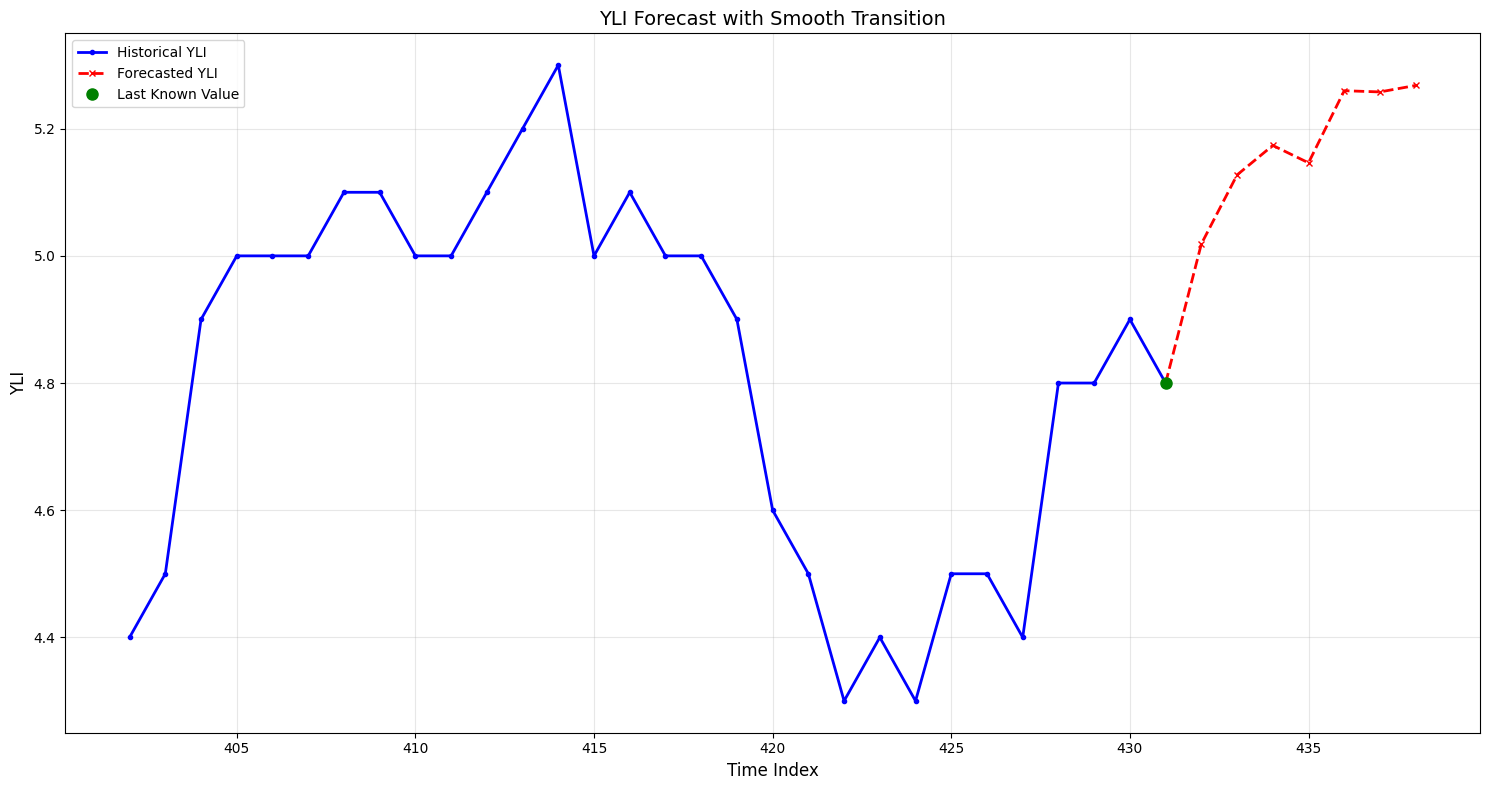

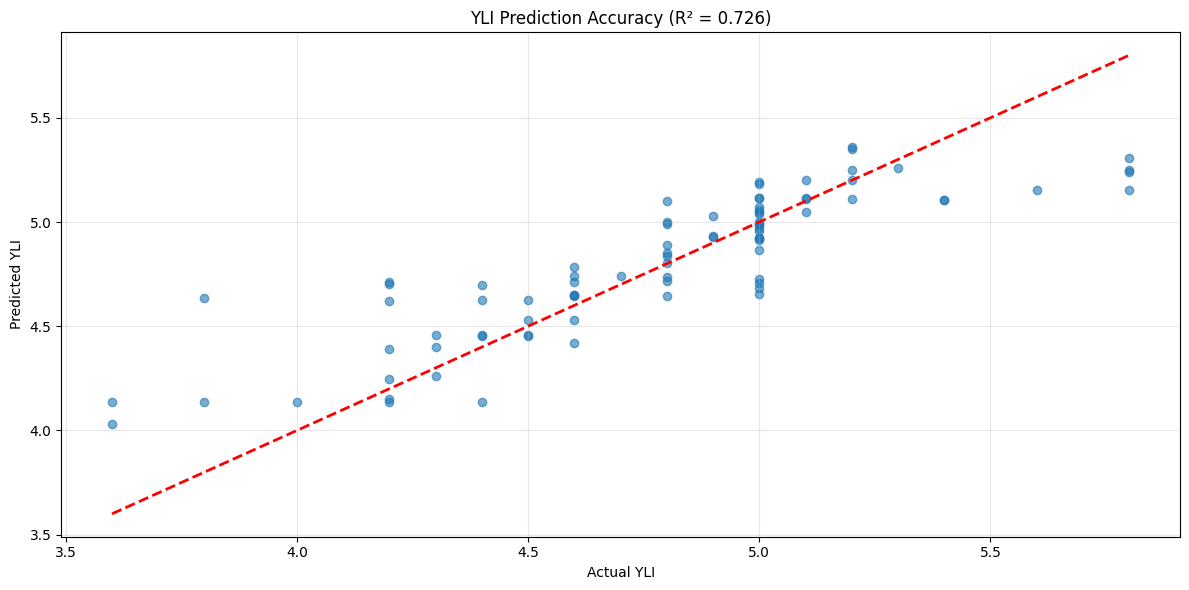


Saved improved models and results to: /content/improved_transformer_yli_forecast

Last historical YLI value: 4.8000
First forecasted YLI value: 5.0187
Difference: 0.2187


In [ ]:
import os
import numpy as np
import pandas as pd
import optuna
import tensorflow as tf
from tensorflow.keras.layers import (Input, MultiHeadAttention, LayerNormalization,
                                     Dense, Dropout, GlobalAveragePooling1D,
                                     Conv1D, Reshape, concatenate, LSTM, TimeDistributed)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# Config / Paths
# ============================================
CSV_PATH = '/content/drive/MyDrive/AGRI/Forecasting/yli_raw2.csv'
TARGET_COL = 'YLI'
DROP_COLS = ['Control']
TEST_SIZE = 0.2
VAL_SIZE = 0.2
NUM_TRIALS = 25
MAX_EPOCHS = 150
FORECAST_DAYS = 7

# ============================================
# Utilities
# ============================================
def load_and_clean(csv_path, target_col, drop_cols=None):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    if drop_cols:
        for c in drop_cols:
            if c in df.columns:
                df.drop(columns=[c], inplace=True, errors='ignore')

    df.bfill(inplace=True)
    df.ffill(inplace=True)
    df.dropna(inplace=True)

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in data.")

    return df

def create_sequences(X, y, time_steps, forecast_horizon=1):
    """Make rolling sequences of length `time_steps` to predict next-step y."""
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps:i+time_steps+forecast_horizon])
    return np.array(Xs), np.array(ys)

def create_single_step_sequences(X, y, time_steps):
    """Create sequences for single-step prediction (smoother transitions)"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

def create_multi_output_sequences(data, time_steps, forecast_horizon=1):
    """Create sequences for multi-output prediction (all features)"""
    Xs, ys = [], []
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        Xs.append(data[i:i+time_steps])
        ys.append(data[i+time_steps:i+time_steps+forecast_horizon])
    return np.array(Xs), np.array(ys)

def nse_score(y_true, y_pred):
    """Nash–Sutcliffe Efficiency."""
    num = np.sum((y_true - y_pred)**2)
    den = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (num / den)

def build_single_step_predictor(input_timesteps, n_features, d_model, num_heads, ff_dim, dropout):
    """Single-step predictor for smoother transitions"""
    inputs = Input(shape=(input_timesteps, n_features))

    # Self attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward block with residual
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(n_features, activation='relu')(ff)
    x = x + ff
    x = LayerNormalization(epsilon=1e-6)(x)

    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)

    # Output layer for single YLI value
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

def build_covariate_single_step_predictor(input_timesteps, n_features, d_model, num_heads, ff_dim, dropout):
    """Single-step covariate predictor for smoother transitions"""
    inputs = Input(shape=(input_timesteps, n_features))

    # Self attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward block with residual
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(n_features, activation='relu')(ff)
    x = x + ff
    x = LayerNormalization(epsilon=1e-6)(x)

    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)

    # Output layer for all features (single step)
    outputs = Dense(n_features)(x)

    model = Model(inputs, outputs)
    return model

def train_eval_single_step_yli_predictor(params, X, y, scaler_y):
    """Train and evaluate single-step YLI predictor."""
    time_steps = params['time_steps']

    # Create single-step sequences
    X_seq, y_seq = create_single_step_sequences(X, y, time_steps)
    if len(X_seq) < 20:
        return 1e9

    # Split into train/val/test
    N = len(X_seq)
    test_count = int(N * TEST_SIZE)
    if test_count == 0: test_count = 1
    X_trainval, X_test = X_seq[:-test_count], X_seq[-test_count:]
    y_trainval, y_test = y_seq[:-test_count], y_seq[-test_count:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=VAL_SIZE, shuffle=True, random_state=42
    )

    # Build & compile model
    n_features = X_seq.shape[2]
    model = build_single_step_predictor(
        input_timesteps=time_steps,
        n_features=n_features,
        d_model=params['d_model'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout=params['dropout']
    )
    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train
    model.fit(
        X_train, y_train,
        epochs=MAX_EPOCHS,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predict on test and compute RMSE in original scale
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform back to original units
    y_pred_orig = scaler_y.inverse_transform(y_pred)
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    return rmse

def train_eval_single_step_covariate_predictor(params, X, scaler_X):
    """Train and evaluate single-step covariate predictor."""
    time_steps = params['time_steps']

    # Create single-step sequences
    X_seq, y_seq = create_single_step_sequences(X, X, time_steps)
    if len(X_seq) < 20:
        return 1e9

    # Split into train/val/test
    N = len(X_seq)
    test_count = int(N * TEST_SIZE)
    if test_count == 0: test_count = 1
    X_trainval, X_test = X_seq[:-test_count], X_seq[-test_count:]
    y_trainval, y_test = y_seq[:-test_count], y_seq[-test_count:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=VAL_SIZE, shuffle=True, random_state=42
    )

    # Build & compile model
    n_features = X_seq.shape[2]
    model = build_covariate_single_step_predictor(
        input_timesteps=time_steps,
        n_features=n_features,
        d_model=params['d_model'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout=params['dropout']
    )
    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train
    model.fit(
        X_train, y_train,
        epochs=MAX_EPOCHS,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predict on test and compute RMSE in original scale
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform back to original units
    y_pred_orig = scaler_X.inverse_transform(y_pred)
    y_test_orig = scaler_X.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    return rmse

def iterative_forecast(model_covariate, model_yli, last_sequence, n_steps, scaler_X, scaler_y):
    """
    Perform iterative forecasting for smoother transitions.
    Each prediction becomes input for the next step.
    """
    forecasted_features = []
    forecasted_yli = []

    # Start with the last known sequence
    current_sequence = last_sequence.copy()

    for step in range(n_steps):
        # Predict next step covariates
        next_covariates_scaled = model_covariate.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)

        # Predict next step YLI
        next_yli_scaled = model_yli.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)

        # Convert to original scale
        next_covariates = scaler_X.inverse_transform(next_covariates_scaled)
        next_yli = scaler_y.inverse_transform(next_yli_scaled)

        # Store predictions
        forecasted_features.append(next_covariates[0])
        forecasted_yli.append(next_yli[0, 0])

        # Create next input sequence by rolling forward
        # Add the new predicted values as the next time step
        new_row = next_covariates_scaled[0]  # Keep in scaled form for next prediction
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return np.array(forecasted_features), np.array(forecasted_yli)

# ============================================
# Load & Scale Data
# ============================================
df = load_and_clean(CSV_PATH, TARGET_COL, drop_cols=DROP_COLS)

y_raw = df[TARGET_COL].values.reshape(-1, 1)
X_raw = df.drop(columns=[TARGET_COL]).values

scaler_X = MinMaxScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).ravel()

print(f"Data rows: {len(df)}, features: {X_scaled.shape[1]}")

# ============================================
# Optuna Hyperparameter Search
# ============================================
def objective_yli_single_step(trial):
    params = {
        'd_model': trial.suggest_categorical('d_model', [32, 64, 128]),
        'num_heads': trial.suggest_categorical('num_heads', [2, 4, 8]),
        'ff_dim': trial.suggest_categorical('ff_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.05, 0.35),
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'time_steps': trial.suggest_categorical('time_steps', [4, 6, 8, 12])
    }

    d_model = params['d_model']
    heads = params['num_heads']
    if d_model % heads != 0:
        return 1e9

    rmse = train_eval_single_step_yli_predictor(params, X_scaled, y_scaled, scaler_y)
    return rmse

def objective_covariate_single_step(trial):
    params = {
        'd_model': trial.suggest_categorical('d_model', [32, 64, 128]),
        'num_heads': trial.suggest_categorical('num_heads', [2, 4, 8]),
        'ff_dim': trial.suggest_categorical('ff_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.05, 0.35),
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'time_steps': trial.suggest_categorical('time_steps', [4, 6, 8, 12])
    }

    d_model = params['d_model']
    heads = params['num_heads']
    if d_model % heads != 0:
        return 1e9

    rmse = train_eval_single_step_covariate_predictor(params, X_scaled, scaler_X)
    return rmse

print("Optimizing single-step YLI predictor...")
study_yli = optuna.create_study(direction='minimize')
study_yli.optimize(objective_yli_single_step, n_trials=NUM_TRIALS, show_progress_bar=True)

print("\nOptimizing single-step covariate predictor...")
study_covariate = optuna.create_study(direction='minimize')
study_covariate.optimize(objective_covariate_single_step, n_trials=NUM_TRIALS, show_progress_bar=True)

print(f"\nBest YLI predictor RMSE: {study_yli.best_value:.6f}")
print("YLI Params:", study_yli.best_params)

print(f"\nBest Covariate predictor RMSE: {study_covariate.best_value:.6f}")
print("Covariate Params:", study_covariate.best_params)

best_params_yli = study_yli.best_params
best_params_covariate = study_covariate.best_params

# ============================================
# Train Final Models
# ============================================
# Train YLI predictor
time_steps_yli = best_params_yli['time_steps']
X_seq_yli, y_seq_yli = create_single_step_sequences(X_scaled, y_scaled, time_steps_yli)

N_yli = len(X_seq_yli)
test_count_yli = int(N_yli * TEST_SIZE)
test_count_yli = max(test_count_yli, 1)
X_trainval_yli, X_test_yli = X_seq_yli[:-test_count_yli], X_seq_yli[-test_count_yli:]
y_trainval_yli, y_test_yli = y_seq_yli[:-test_count_yli], y_seq_yli[-test_count_yli:]

X_train_yli, X_val_yli, y_train_yli, y_val_yli = train_test_split(
    X_trainval_yli, y_trainval_yli, test_size=VAL_SIZE, shuffle=True, random_state=42
)

n_features = X_seq_yli.shape[2]
model_yli = build_single_step_predictor(
    input_timesteps=time_steps_yli,
    n_features=n_features,
    d_model=best_params_yli['d_model'],
    num_heads=best_params_yli['num_heads'],
    ff_dim=best_params_yli['ff_dim'],
    dropout=best_params_yli['dropout']
)
model_yli.compile(optimizer=Adam(learning_rate=best_params_yli['lr']), loss='mse')

es_yli = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
rlrop_yli = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

print("Training YLI predictor...")
history_yli = model_yli.fit(
    X_train_yli, y_train_yli,
    epochs=MAX_EPOCHS,
    batch_size=best_params_yli['batch_size'],
    validation_data=(X_val_yli, y_val_yli),
    verbose=1,
    callbacks=[es_yli, rlrop_yli]
)

# Train covariate predictor
time_steps_covariate = best_params_covariate['time_steps']
X_seq_covariate, y_seq_covariate = create_single_step_sequences(X_scaled, X_scaled, time_steps_covariate)

N_covariate = len(X_seq_covariate)
test_count_covariate = int(N_covariate * TEST_SIZE)
test_count_covariate = max(test_count_covariate, 1)
X_trainval_covariate, X_test_covariate = X_seq_covariate[:-test_count_covariate], X_seq_covariate[-test_count_covariate:]
y_trainval_covariate, y_test_covariate = y_seq_covariate[:-test_count_covariate], y_seq_covariate[-test_count_covariate:]

X_train_covariate, X_val_covariate, y_train_covariate, y_val_covariate = train_test_split(
    X_trainval_covariate, y_trainval_covariate, test_size=VAL_SIZE, shuffle=True, random_state=42
)

model_covariate = build_covariate_single_step_predictor(
    input_timesteps=time_steps_covariate,
    n_features=n_features,
    d_model=best_params_covariate['d_model'],
    num_heads=best_params_covariate['num_heads'],
    ff_dim=best_params_covariate['ff_dim'],
    dropout=best_params_covariate['dropout']
)
model_covariate.compile(optimizer=Adam(learning_rate=best_params_covariate['lr']), loss='mse')

es_covariate = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
rlrop_covariate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

print("Training covariate predictor...")
history_covariate = model_covariate.fit(
    X_train_covariate, y_train_covariate,
    epochs=MAX_EPOCHS,
    batch_size=best_params_covariate['batch_size'],
    validation_data=(X_val_covariate, y_val_covariate),
    verbose=1,
    callbacks=[es_covariate, rlrop_covariate]
)

# ============================================
# Evaluate Models
# ============================================
# Evaluate YLI predictor
y_pred_yli = model_yli.predict(X_test_yli)
y_pred_yli_orig = scaler_y.inverse_transform(y_pred_yli)
y_test_yli_orig = scaler_y.inverse_transform(y_test_yli.reshape(-1, 1))

rmse_yli = np.sqrt(mean_squared_error(y_test_yli_orig, y_pred_yli_orig))
mae_yli = mean_absolute_error(y_test_yli_orig, y_pred_yli_orig)
r2_yli = r2_score(y_test_yli_orig, y_pred_yli_orig)
nse_yli = nse_score(y_test_yli_orig.flatten(), y_pred_yli_orig.flatten())
mape_yli = np.mean(np.abs((y_test_yli_orig - y_pred_yli_orig) / np.maximum(np.abs(y_test_yli_orig), 1e-8))) * 100

print("\n================ YLI PREDICTOR METRICS ================")
print(f"RMSE : {rmse_yli:.6f}")
print(f"MAE  : {mae_yli:.6f}")
print(f"R²   : {r2_yli:.6f}")
print(f"NSE  : {nse_yli:.6f}")
print(f"MAPE : {mape_yli:.3f}%")

# ============================================
# Iterative Forecast
# ============================================
# Use the longer time_steps for the forecast
max_time_steps = max(time_steps_yli, time_steps_covariate)
last_sequence = X_scaled[-max_time_steps:]

print(f"Performing iterative forecast for {FORECAST_DAYS} days...")
future_covariates, future_yli = iterative_forecast(
    model_covariate, model_yli, last_sequence, FORECAST_DAYS, scaler_X, scaler_y
)

# Create future dates
last_date = df.index[-1] if hasattr(df.index, 'dtype') and pd.api.types.is_datetime64_any_dtype(df.index) else len(df)
if isinstance(last_date, (int, float, np.integer)):
    future_dates = [last_date + i + 1 for i in range(FORECAST_DAYS)]
else:
    future_dates = [last_date + timedelta(days=i+1) for i in range(FORECAST_DAYS)]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_YLI": future_yli
})

# Add predicted covariates
for i, col in enumerate(df.drop(columns=[TARGET_COL]).columns):
    forecast_df[f"Predicted_{col}"] = future_covariates[:, i]

print("\n================ ITERATIVE FORECAST ================")
print(forecast_df)

# ============================================
# Improved Plotting
# ============================================
# Plot with smoother transitions
plt.figure(figsize=(15, 8))

# Historical data (last 30 points)
historical_yli = df[TARGET_COL].values[-30:]
historical_dates = list(range(len(df)-30, len(df)))

# Plot historical
plt.plot(historical_dates, historical_yli, 'b-', label='Historical YLI', linewidth=2, marker='o', markersize=3)

# Plot forecast with connection to last historical point
forecast_dates_extended = [len(df)-1] + [len(df) + i for i in range(FORECAST_DAYS)]
forecast_values_extended = [df[TARGET_COL].values[-1]] + list(future_yli)

plt.plot(forecast_dates_extended, forecast_values_extended, 'r--',
         label='Forecasted YLI', linewidth=2, marker='x', markersize=5)

# Highlight the connection point
plt.plot(len(df)-1, df[TARGET_COL].values[-1], 'go', markersize=8,
         label='Last Known Value')

plt.title('YLI Forecast with Smooth Transition', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel(TARGET_COL, fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction accuracy on test set
plt.figure(figsize=(12, 6))
plt.scatter(y_test_yli_orig, y_pred_yli_orig, alpha=0.6)
plt.plot([y_test_yli_orig.min(), y_test_yli_orig.max()],
         [y_test_yli_orig.min(), y_test_yli_orig.max()], 'r--', linewidth=2)
plt.xlabel('Actual YLI')
plt.ylabel('Predicted YLI')
plt.title(f'YLI Prediction Accuracy (R² = {r2_yli:.3f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# Save Results
# ============================================
SAVE_DIR = '/content/improved_transformer_yli_forecast'
os.makedirs(SAVE_DIR, exist_ok=True)

model_covariate.save(os.path.join(SAVE_DIR, 'covariate_predictor.h5'))
model_yli.save(os.path.join(SAVE_DIR, 'yli_predictor.h5'))

joblib.dump(scaler_X, os.path.join(SAVE_DIR, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(SAVE_DIR, 'scaler_y.pkl'))

pd.Series(best_params_covariate).to_json(os.path.join(SAVE_DIR, 'best_params_covariate.json'))
pd.Series(best_params_yli).to_json(os.path.join(SAVE_DIR, 'best_params_yli.json'))

forecast_df.to_csv(os.path.join(SAVE_DIR, 'iterative_forecast_results.csv'), index=False)

# Save model configuration for easy reloading
config = {
    'time_steps_yli': time_steps_yli,
    'time_steps_covariate': time_steps_covariate,
    'n_features': n_features,
    'forecast_days': FORECAST_DAYS
}
pd.Series(config).to_json(os.path.join(SAVE_DIR, 'model_config.json'))

print(f"\nSaved improved models and results to: {SAVE_DIR}")

# Show the transition more clearly
print(f"\nLast historical YLI value: {df[TARGET_COL].values[-1]:.4f}")
print(f"First forecasted YLI value: {future_yli[0]:.4f}")
print(f"Difference: {abs(future_yli[0] - df[TARGET_COL].values[-1]):.4f}")

[I 2025-09-15 06:29:13,283] A new study created in memory with name: no-name-18852c22-6ea4-4ca0-9473-0b14bf536f03


Data rows: 432, features: 20
Optimizing LSTM YLI predictor...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-09-15 06:31:52,497] Trial 0 finished with value: 0.3590652603508792 and parameters: {'lstm_units': 64, 'num_layers': 2, 'dropout': 0.2033683530837793, 'recurrent_dropout': 0.12358438077762246, 'use_bidirectional': True, 'lr': 0.00023022499505691345, 'batch_size': 32, 'time_steps': 14}. Best is trial 0 with value: 0.3590652603508792.
[I 2025-09-15 06:32:34,311] Trial 1 finished with value: 0.41602374246739826 and parameters: {'lstm_units': 64, 'num_layers': 3, 'dropout': 0.3886151067792514, 'recurrent_dropout': 0.17682162520689113, 'use_bidirectional': False, 'lr': 0.0014061166290802376, 'batch_size': 16, 'time_steps': 5}. Best is trial 0 with value: 0.3590652603508792.


[I 2025-09-15 06:33:53,561] Trial 2 finished with value: 0.4118457040823033 and parameters: {'lstm_units': 256, 'num_layers': 1, 'dropout': 0.2570104874340446, 'recurrent_dropout': 0.27261171998532896, 'use_bidirectional': False, 'lr': 0.00018204278499617168, 'batch_size': 32, 'time_steps': 5}. Best is trial 0 with value: 0.3590652603508792.
[I 2025-09-15 06:35:10,232] Trial 3 finished with value: 0.5985002912114535 and parameters: {'lstm_units': 256, 'num_layers': 3, 'dropout': 0.33964575719115053, 'recurrent_dropout': 0.06324986040578691, 'use_bidirectional': False, 'lr': 0.0008484378936545238, 'batch_size': 128, 'time_steps': 20}. Best is trial 0 with value: 0.3590652603508792.
[I 2025-09-15 06:36:16,681] Trial 4 finished with value: 0.3826448257713702 and parameters: {'lstm_units': 64, 'num_layers': 3, 'dropout': 0.173674149081828, 'recurrent_dropout': 0.026885608030843278, 'use_bidirectional': False, 'lr': 0.00014510243841968156, 'batch_size': 128, 'time_steps': 10}. Best is trial

[I 2025-09-15 07:11:36,749] A new study created in memory with name: no-name-ca269a37-de0b-47cc-94db-365decb0759f


[I 2025-09-15 07:11:36,743] Trial 24 finished with value: 0.31590516960328 and parameters: {'lstm_units': 128, 'num_layers': 2, 'dropout': 0.15645473262723952, 'recurrent_dropout': 0.11386022594161929, 'use_bidirectional': True, 'lr': 0.001867119574478601, 'batch_size': 64, 'time_steps': 10}. Best is trial 14 with value: 0.27865329052999743.

Optimizing LSTM covariate predictor...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-09-15 07:12:13,662] Trial 0 finished with value: 14.317751903853187 and parameters: {'lstm_units': 128, 'num_layers': 1, 'dropout': 0.25287254174928175, 'recurrent_dropout': 0.2764961337372305, 'use_bidirectional': False, 'lr': 0.00013300268277071774, 'batch_size': 64, 'time_steps': 20}. Best is trial 0 with value: 14.317751903853187.
[I 2025-09-15 07:12:39,519] Trial 1 finished with value: 14.363033982663465 and parameters: {'lstm_units': 64, 'num_layers': 1, 'dropout': 0.24143495944703186, 'recurrent_dropout': 0.04296461651423415, 'use_bidirectional': False, 'lr': 0.00015186482607261633, 'batch_size': 32, 'time_steps': 14}. Best is trial 0 with value: 14.317751903853187.
[I 2025-09-15 07:13:15,801] Trial 2 finished with value: 13.281984443971101 and parameters: {'lstm_units': 64, 'num_layers': 1, 'dropout': 0.22476089242422972, 'recurrent_dropout': 0.2517347097311004, 'use_bidirectional': True, 'lr': 0.00436941820684427, 'batch_size': 64, 'time_steps': 10}. Best is trial 2 wi

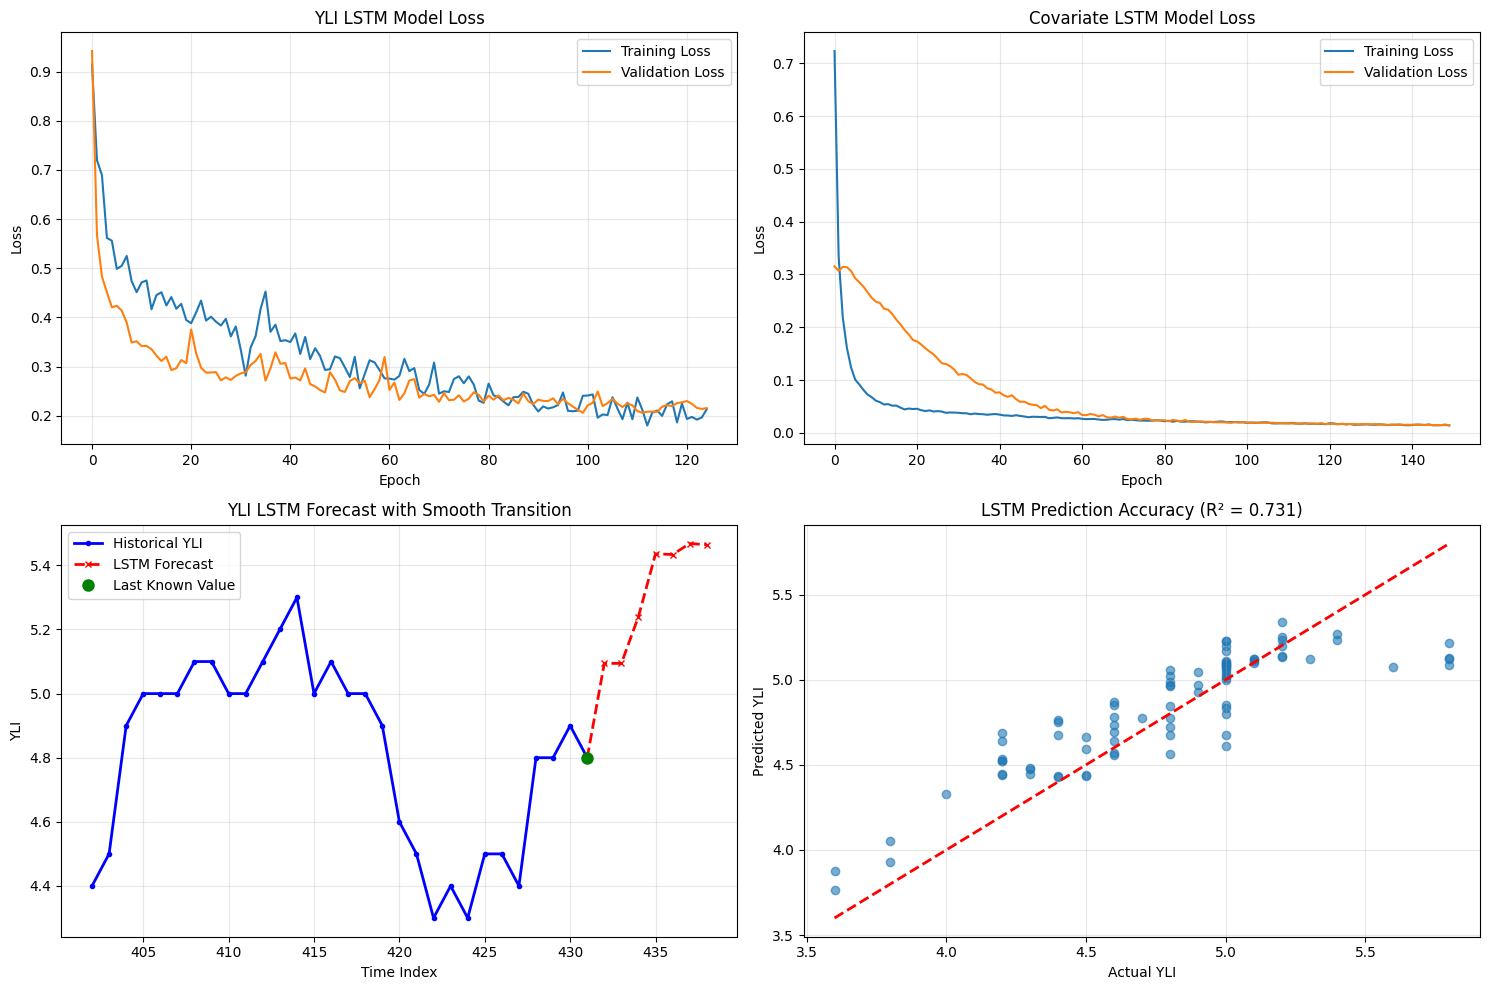

In [ ]:
import os
import numpy as np
import pandas as pd
import optuna
import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout,
                                     BatchNormalization, Bidirectional)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# Config / Paths
# ============================================
CSV_PATH = '/content/drive/MyDrive/AGRI/Forecasting/yli_raw2.csv'
TARGET_COL = 'YLI'
DROP_COLS = ['Control']
TEST_SIZE = 0.2
VAL_SIZE = 0.2
NUM_TRIALS = 25
MAX_EPOCHS = 150
FORECAST_DAYS = 7

# ============================================
# Utilities
# ============================================
def load_and_clean(csv_path, target_col, drop_cols=None):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    if drop_cols:
        for c in drop_cols:
            if c in df.columns:
                df.drop(columns=[c], inplace=True, errors='ignore')

    df.bfill(inplace=True)
    df.ffill(inplace=True)
    df.dropna(inplace=True)

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in data.")

    return df

def create_sequences(X, y, time_steps, forecast_horizon=1):
    """Make rolling sequences of length `time_steps` to predict next-step y."""
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps:i+time_steps+forecast_horizon])
    return np.array(Xs), np.array(ys)

def create_single_step_sequences(X, y, time_steps):
    """Create sequences for single-step prediction (smoother transitions)"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

def nse_score(y_true, y_pred):
    """Nash–Sutcliffe Efficiency."""
    num = np.sum((y_true - y_pred)**2)
    den = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (num / den)

def build_lstm_yli_predictor(input_timesteps, n_features, lstm_units, num_layers,
                            dropout, recurrent_dropout, use_bidirectional=False):
    """LSTM-based single-step YLI predictor"""
    inputs = Input(shape=(input_timesteps, n_features))

    x = inputs

    # Stack LSTM layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for all but last layer

        if use_bidirectional:
            x = Bidirectional(
                LSTM(lstm_units,
                     return_sequences=return_sequences,
                     dropout=dropout,
                     recurrent_dropout=recurrent_dropout)
            )(x)
        else:
            x = LSTM(lstm_units,
                     return_sequences=return_sequences,
                     dropout=dropout,
                     recurrent_dropout=recurrent_dropout)(x)

        # Add batch normalization for deeper networks
        if num_layers > 2:
            x = BatchNormalization()(x)

    # Final dense layers
    x = Dropout(dropout)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout)(x)

    # Output layer for single YLI value
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

def build_lstm_covariate_predictor(input_timesteps, n_features, lstm_units, num_layers,
                                  dropout, recurrent_dropout, use_bidirectional=False):
    """LSTM-based single-step covariate predictor"""
    inputs = Input(shape=(input_timesteps, n_features))

    x = inputs

    # Stack LSTM layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)

        if use_bidirectional:
            x = Bidirectional(
                LSTM(lstm_units,
                     return_sequences=return_sequences,
                     dropout=dropout,
                     recurrent_dropout=recurrent_dropout)
            )(x)
        else:
            x = LSTM(lstm_units,
                     return_sequences=return_sequences,
                     dropout=dropout,
                     recurrent_dropout=recurrent_dropout)(x)

        # Add batch normalization for deeper networks
        if num_layers > 2:
            x = BatchNormalization()(x)

    # Final dense layers
    x = Dropout(dropout)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout)(x)

    # Output layer for all features (single step)
    outputs = Dense(n_features)(x)

    model = Model(inputs, outputs)
    return model

def train_eval_lstm_yli_predictor(params, X, y, scaler_y):
    """Train and evaluate LSTM YLI predictor."""
    time_steps = params['time_steps']

    # Create single-step sequences
    X_seq, y_seq = create_single_step_sequences(X, y, time_steps)
    if len(X_seq) < 20:
        return 1e9

    # Split into train/val/test
    N = len(X_seq)
    test_count = int(N * TEST_SIZE)
    if test_count == 0: test_count = 1
    X_trainval, X_test = X_seq[:-test_count], X_seq[-test_count:]
    y_trainval, y_test = y_seq[:-test_count], y_seq[-test_count:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=VAL_SIZE, shuffle=True, random_state=42
    )

    # Build & compile model
    n_features = X_seq.shape[2]
    model = build_lstm_yli_predictor(
        input_timesteps=time_steps,
        n_features=n_features,
        lstm_units=params['lstm_units'],
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        recurrent_dropout=params['recurrent_dropout'],
        use_bidirectional=params['use_bidirectional']
    )

    # Use gradient clipping to prevent exploding gradients
    optimizer = Adam(learning_rate=params['lr'], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train
    model.fit(
        X_train, y_train,
        epochs=MAX_EPOCHS,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predict on test and compute RMSE in original scale
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform back to original units
    y_pred_orig = scaler_y.inverse_transform(y_pred)
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    return rmse

def train_eval_lstm_covariate_predictor(params, X, scaler_X):
    """Train and evaluate LSTM covariate predictor."""
    time_steps = params['time_steps']

    # Create single-step sequences
    X_seq, y_seq = create_single_step_sequences(X, X, time_steps)
    if len(X_seq) < 20:
        return 1e9

    # Split into train/val/test
    N = len(X_seq)
    test_count = int(N * TEST_SIZE)
    if test_count == 0: test_count = 1
    X_trainval, X_test = X_seq[:-test_count], X_seq[-test_count:]
    y_trainval, y_test = y_seq[:-test_count], y_seq[-test_count:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=VAL_SIZE, shuffle=True, random_state=42
    )

    # Build & compile model
    n_features = X_seq.shape[2]
    model = build_lstm_covariate_predictor(
        input_timesteps=time_steps,
        n_features=n_features,
        lstm_units=params['lstm_units'],
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        recurrent_dropout=params['recurrent_dropout'],
        use_bidirectional=params['use_bidirectional']
    )

    # Use gradient clipping
    optimizer = Adam(learning_rate=params['lr'], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train
    model.fit(
        X_train, y_train,
        epochs=MAX_EPOCHS,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[es, rlrop]
    )

    # Predict on test and compute RMSE in original scale
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform back to original units
    y_pred_orig = scaler_X.inverse_transform(y_pred)
    y_test_orig = scaler_X.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    return rmse

def iterative_forecast(model_covariate, model_yli, last_sequence, n_steps, scaler_X, scaler_y):
    """
    Perform iterative forecasting for smoother transitions.
    Each prediction becomes input for the next step.
    """
    forecasted_features = []
    forecasted_yli = []

    # Start with the last known sequence
    current_sequence = last_sequence.copy()

    for step in range(n_steps):
        # Predict next step covariates
        next_covariates_scaled = model_covariate.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)

        # Predict next step YLI
        next_yli_scaled = model_yli.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)

        # Convert to original scale
        next_covariates = scaler_X.inverse_transform(next_covariates_scaled)
        next_yli = scaler_y.inverse_transform(next_yli_scaled)

        # Store predictions
        forecasted_features.append(next_covariates[0])
        forecasted_yli.append(next_yli[0, 0])

        # Create next input sequence by rolling forward
        # Add the new predicted values as the next time step
        new_row = next_covariates_scaled[0]  # Keep in scaled form for next prediction
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return np.array(forecasted_features), np.array(forecasted_yli)

# ============================================
# Load & Scale Data
# ============================================
df = load_and_clean(CSV_PATH, TARGET_COL, drop_cols=DROP_COLS)

y_raw = df[TARGET_COL].values.reshape(-1, 1)
X_raw = df.drop(columns=[TARGET_COL]).values

scaler_X = MinMaxScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).ravel()

print(f"Data rows: {len(df)}, features: {X_scaled.shape[1]}")

# ============================================
# Optuna Hyperparameter Search
# ============================================
def objective_lstm_yli(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [32, 64, 128, 256]),
        'num_layers': trial.suggest_categorical('num_layers', [1, 2, 3]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'recurrent_dropout': trial.suggest_float('recurrent_dropout', 0.0, 0.3),
        'use_bidirectional': trial.suggest_categorical('use_bidirectional', [True, False]),
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'time_steps': trial.suggest_categorical('time_steps', [5, 7, 10, 14, 20])
    }

    rmse = train_eval_lstm_yli_predictor(params, X_scaled, y_scaled, scaler_y)
    return rmse

def objective_lstm_covariate(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [32, 64, 128, 256]),
        'num_layers': trial.suggest_categorical('num_layers', [1, 2, 3]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'recurrent_dropout': trial.suggest_float('recurrent_dropout', 0.0, 0.3),
        'use_bidirectional': trial.suggest_categorical('use_bidirectional', [True, False]),
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'time_steps': trial.suggest_categorical('time_steps', [5, 7, 10, 14, 20])
    }

    rmse = train_eval_lstm_covariate_predictor(params, X_scaled, scaler_X)
    return rmse

print("Optimizing LSTM YLI predictor...")
study_yli = optuna.create_study(direction='minimize')
study_yli.optimize(objective_lstm_yli, n_trials=NUM_TRIALS, show_progress_bar=True)

print("\nOptimizing LSTM covariate predictor...")
study_covariate = optuna.create_study(direction='minimize')
study_covariate.optimize(objective_lstm_covariate, n_trials=NUM_TRIALS, show_progress_bar=True)

print(f"\nBest YLI predictor RMSE: {study_yli.best_value:.6f}")
print("YLI Params:", study_yli.best_params)

print(f"\nBest Covariate predictor RMSE: {study_covariate.best_value:.6f}")
print("Covariate Params:", study_covariate.best_params)

best_params_yli = study_yli.best_params
best_params_covariate = study_covariate.best_params

# ============================================
# Train Final Models
# ============================================
# Train YLI predictor
time_steps_yli = best_params_yli['time_steps']
X_seq_yli, y_seq_yli = create_single_step_sequences(X_scaled, y_scaled, time_steps_yli)

N_yli = len(X_seq_yli)
test_count_yli = int(N_yli * TEST_SIZE)
test_count_yli = max(test_count_yli, 1)
X_trainval_yli, X_test_yli = X_seq_yli[:-test_count_yli], X_seq_yli[-test_count_yli:]
y_trainval_yli, y_test_yli = y_seq_yli[:-test_count_yli], y_seq_yli[-test_count_yli:]

X_train_yli, X_val_yli, y_train_yli, y_val_yli = train_test_split(
    X_trainval_yli, y_trainval_yli, test_size=VAL_SIZE, shuffle=True, random_state=42
)

n_features = X_seq_yli.shape[2]
model_yli = build_lstm_yli_predictor(
    input_timesteps=time_steps_yli,
    n_features=n_features,
    lstm_units=best_params_yli['lstm_units'],
    num_layers=best_params_yli['num_layers'],
    dropout=best_params_yli['dropout'],
    recurrent_dropout=best_params_yli['recurrent_dropout'],
    use_bidirectional=best_params_yli['use_bidirectional']
)

optimizer_yli = Adam(learning_rate=best_params_yli['lr'], clipnorm=1.0)
model_yli.compile(optimizer=optimizer_yli, loss='mse')

es_yli = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
rlrop_yli = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

print("Training LSTM YLI predictor...")
history_yli = model_yli.fit(
    X_train_yli, y_train_yli,
    epochs=MAX_EPOCHS,
    batch_size=best_params_yli['batch_size'],
    validation_data=(X_val_yli, y_val_yli),
    verbose=1,
    callbacks=[es_yli, rlrop_yli]
)

# Train covariate predictor
time_steps_covariate = best_params_covariate['time_steps']
X_seq_covariate, y_seq_covariate = create_single_step_sequences(X_scaled, X_scaled, time_steps_covariate)

N_covariate = len(X_seq_covariate)
test_count_covariate = int(N_covariate * TEST_SIZE)
test_count_covariate = max(test_count_covariate, 1)
X_trainval_covariate, X_test_covariate = X_seq_covariate[:-test_count_covariate], X_seq_covariate[-test_count_covariate:]
y_trainval_covariate, y_test_covariate = y_seq_covariate[:-test_count_covariate], y_seq_covariate[-test_count_covariate:]

X_train_covariate, X_val_covariate, y_train_covariate, y_val_covariate = train_test_split(
    X_trainval_covariate, y_trainval_covariate, test_size=VAL_SIZE, shuffle=True, random_state=42
)

model_covariate = build_lstm_covariate_predictor(
    input_timesteps=time_steps_covariate,
    n_features=n_features,
    lstm_units=best_params_covariate['lstm_units'],
    num_layers=best_params_covariate['num_layers'],
    dropout=best_params_covariate['dropout'],
    recurrent_dropout=best_params_covariate['recurrent_dropout'],
    use_bidirectional=best_params_covariate['use_bidirectional']
)

optimizer_covariate = Adam(learning_rate=best_params_covariate['lr'], clipnorm=1.0)
model_covariate.compile(optimizer=optimizer_covariate, loss='mse')

es_covariate = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
rlrop_covariate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

print("Training LSTM covariate predictor...")
history_covariate = model_covariate.fit(
    X_train_covariate, y_train_covariate,
    epochs=MAX_EPOCHS,
    batch_size=best_params_covariate['batch_size'],
    validation_data=(X_val_covariate, y_val_covariate),
    verbose=1,
    callbacks=[es_covariate, rlrop_covariate]
)

# ============================================
# Evaluate Models
# ============================================
# Evaluate YLI predictor
y_pred_yli = model_yli.predict(X_test_yli)
y_pred_yli_orig = scaler_y.inverse_transform(y_pred_yli)
y_test_yli_orig = scaler_y.inverse_transform(y_test_yli.reshape(-1, 1))

rmse_yli = np.sqrt(mean_squared_error(y_test_yli_orig, y_pred_yli_orig))
mae_yli = mean_absolute_error(y_test_yli_orig, y_pred_yli_orig)
r2_yli = r2_score(y_test_yli_orig, y_pred_yli_orig)
nse_yli = nse_score(y_test_yli_orig.flatten(), y_pred_yli_orig.flatten())
mape_yli = np.mean(np.abs((y_test_yli_orig - y_pred_yli_orig) / np.maximum(np.abs(y_test_yli_orig), 1e-8))) * 100

print("\n================ LSTM YLI PREDICTOR METRICS ================")
print(f"RMSE : {rmse_yli:.6f}")
print(f"MAE  : {mae_yli:.6f}")
print(f"R²   : {r2_yli:.6f}")
print(f"NSE  : {nse_yli:.6f}")
print(f"MAPE : {mape_yli:.3f}%")

# Show model architecture
print(f"\n================ FINAL MODEL ARCHITECTURES ================")
print("YLI Predictor:")
print(f"  - LSTM Units: {best_params_yli['lstm_units']}")
print(f"  - Layers: {best_params_yli['num_layers']}")
print(f"  - Bidirectional: {best_params_yli['use_bidirectional']}")
print(f"  - Time Steps: {time_steps_yli}")

print("\nCovariate Predictor:")
print(f"  - LSTM Units: {best_params_covariate['lstm_units']}")
print(f"  - Layers: {best_params_covariate['num_layers']}")
print(f"  - Bidirectional: {best_params_covariate['use_bidirectional']}")
print(f"  - Time Steps: {time_steps_covariate}")

# ============================================
# Iterative Forecast
# ============================================
# Use the longer time_steps for the forecast
max_time_steps = max(time_steps_yli, time_steps_covariate)
last_sequence = X_scaled[-max_time_steps:]

print(f"\nPerforming iterative forecast for {FORECAST_DAYS} days...")
future_covariates, future_yli = iterative_forecast(
    model_covariate, model_yli, last_sequence, FORECAST_DAYS, scaler_X, scaler_y
)

# Create future dates
last_date = df.index[-1] if hasattr(df.index, 'dtype') and pd.api.types.is_datetime64_any_dtype(df.index) else len(df)
if isinstance(last_date, (int, float, np.integer)):
    future_dates = [last_date + i + 1 for i in range(FORECAST_DAYS)]
else:
    future_dates = [last_date + timedelta(days=i+1) for i in range(FORECAST_DAYS)]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_YLI": future_yli
})

# Add predicted covariates
for i, col in enumerate(df.drop(columns=[TARGET_COL]).columns):
    forecast_df[f"Predicted_{col}"] = future_covariates[:, i]

print("\n================ LSTM ITERATIVE FORECAST ================")
print(forecast_df)

# ============================================
# Enhanced Plotting
# ============================================
# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# YLI model loss
ax1.plot(history_yli.history['loss'], label='Training Loss')
ax1.plot(history_yli.history['val_loss'], label='Validation Loss')
ax1.set_title('YLI LSTM Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Covariate model loss
ax2.plot(history_covariate.history['loss'], label='Training Loss')
ax2.plot(history_covariate.history['val_loss'], label='Validation Loss')
ax2.set_title('Covariate LSTM Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# YLI forecast with smooth transitions
historical_yli = df[TARGET_COL].values[-30:]
historical_dates = list(range(len(df)-30, len(df)))

ax3.plot(historical_dates, historical_yli, 'b-', label='Historical YLI', linewidth=2, marker='o', markersize=3)

# Plot forecast with connection to last historical point
forecast_dates_extended = [len(df)-1] + [len(df) + i for i in range(FORECAST_DAYS)]
forecast_values_extended = [df[TARGET_COL].values[-1]] + list(future_yli)

ax3.plot(forecast_dates_extended, forecast_values_extended, 'r--',
         label='LSTM Forecast', linewidth=2, marker='x', markersize=5)
ax3.plot(len(df)-1, df[TARGET_COL].values[-1], 'go', markersize=8,
         label='Last Known Value')

ax3.set_title('YLI LSTM Forecast with Smooth Transition')
ax3.set_xlabel('Time Index')
ax3.set_ylabel(TARGET_COL)
ax3.grid(True, alpha=0.3)
ax3.legend()

# Prediction accuracy scatter plot
ax4.scatter(y_test_yli_orig, y_pred_yli_orig, alpha=0.6)
ax4.plot([y_test_yli_orig.min(), y_test_yli_orig.max()],
         [y_test_yli_orig.min(), y_test_yli_orig.max()], 'r--', linewidth=2)
ax4.set_xlabel('Actual YLI')
ax4.set_ylabel('Predicted YLI')
ax4.set_title(f'LSTM Prediction Accuracy (R² = {r2_yli:.3f})')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# Save Results
# ============================================
SAVE_DIR = '/content/lstm_yli_forecast'
os.makedirs(SAVE_DIR, exist_ok=True)

model_covariate.save(os.path.join(SAVE_DIR, 'lstm_covariate_predictor.h5'))
model_yli.save(os.path.join(SAVE_DIR, 'lstm_yli_predictor.h5'))

joblib.dump(scaler_X, os.path.join(SAVE_DIR, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(SAVE_DIR, 'scaler_y.pkl'))

pd.Series(best_params_covariate).to_json(os.path.join(SAVE_DIR, 'best_params_covariate.json'))
pd.Series(best_params_yli).to_json(os.path.join(SAVE_DIR, 'best_params_yli.json'))

forecast_df.to_csv(os.path.join(SAVE_DIR, 'lstm_forecast_results.csv'), index=False)

# Save model configuration
config = {
    'time_steps_yli': time_steps_yli,
    'time_steps_covariate': time_steps_covariate,
    'n_features': n_features,
    'forecast_days': FORECAST_DAYS,
    'model_type': 'LSTM'
}
pd.Series(config).to_json(os.path.join(SAVE_DIR, 'model_config.json'))

# Save training history
pd.DataFrame(history_yli.history).to_csv(os.path.join(SAVE_DIR, 'yli_training_history.csv'), index=False)
pd.DataFrame(history_covariate.history).to_csv(os.path.join(SAVE_DIR, 'covariate_training_history.csv'), index=False)